```
conda install -c conda-forge scikit-learn pandas
```

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

### Primera actividad de redes neuronales

In [51]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_data = cancer.data
y_data = cancer.target

(https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer)
- En el siguiente bloque explore la data, con el fin de responder a estas preguntas.

	I) ¿De que se trata el dataset?

	II) ¿Cuales son las clases de salida?

	III) ¿A que corresponden las caracteristicas?

	IV) ¿Cuantas caracteristicas y clases de salida hay?
	
	V) Etc.

**I)**  Las características se calculan a partir de una imagen digitalizada de un aspirado con aguja fina (AAF) de una masa mamaria.  Describen las características de los núcleos celulares presentes en la imagen.

**II)** Las clases de salida son 2: B (cáncer benigno) y M (cáncer maligno).

**III)** Las características son 30. Aqui van las descripciones de algunas:

	a) radio (media de las distancias del centro a los puntos del perímetro)

	b) textura (desviación típica de los valores de la escala de grises)

	c) perímetro

	d) área

	e) suavidad (variación local de las longitudes de los radios)

	f) compacidad (perímetro^2 / área - 1,0)

	g) concavidad (gravedad de las partes cóncavas del contorno)

	h) puntos cóncavos (número de porciones cóncavas del contorno)

	i) simetría 

	j) dimensión fractal ("aproximación de la línea de costa" - 1)

**IV)** Existen 32 caracteristicas  y dos clases de salida.


In [52]:
import torch
from torch.utils.data import random_split,DataLoader,TensorDataset

X = torch.tensor(X_data, dtype=torch.float32)
Y = torch.tensor(y_data,dtype=torch.long)

dataset = TensorDataset(X,Y)

train_set, valid_set,test_set = random_split(dataset,[342,113,114],generator=torch.Generator().manual_seed(1234)) ##No cambiar la semilla

train_loader = DataLoader(train_set, shuffle=True, batch_size=32)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

## Implentación de la Red Neuronal
- En el siguiente bloque implemente el modelo que utilizará su red neuronal para predecir si un paciente tiene cáncer o no, teniendo en cuenta sus caracteristicas.

In [53]:
import torch.nn as nn

class BreastCancerNN(nn.Module):
	def __init__(self,input_dim,hidden_dim,output_dim):
		super(BreastCancerNN, self).__init__()
		self.hidden = nn.Linear(input_dim, hidden_dim)
		self.output = nn.Linear(hidden_dim, output_dim)
		self.activation = nn.Sigmoid()
	def forward(self, x):
		x = self.hidden(x)
		x = self.activation(x)
		x = self.output(x)
		return x


- En el siguiente bloque cree una instancia de su red neuronal definida anteriormente y defina una función de pérdida y optimizador adecuados:

In [54]:
model = BreastCancerNN(30,15,2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

- Responda: 
	- ¿Porqué eligió esa función de pérdida?
		- Ocupamos CrossEntropyLoss ya que compara la distribucion de probabilidad predicha por el modelo con la distribucion real y clasifica instancias en categorias discretas, que es justo lo que necesitamos para este ejemplo, si tiene o no cancer de mama (0 o 1).
	- Elija 2 optimizadores populares y describalos, luego explique porqué elige uno de los 2.
		- SGD: El Stochastic gradient descent(SGD)  es un método iterativo para optimizar una función objetivo con propiedades de suavidad adecuadas (por ejemplo, diferenciable o subdiferenciable). Puede considerarse una aproximación estocástica de la optimización por descenso de gradiente, ya que sustituye el gradiente real (calculado a partir de todo el conjunto de datos) por una estimación del mismo

		- Adam: The Adaptive Moment Estimation es un algoritmo para la técnica de optimización por descenso de gradiente. El método es realmente eficiente cuando se trabaja con grandes problemas que implican una gran cantidad de datos o parámetros. Requiere menos memoria y es eficiente. Intuitivamente, es una combinación del algoritmo de "gradient descent with momentum" y el algoritmo "RMSP".
	
	- **Elegimos Adamn** porque, segun la documentacion, es un algoritmo mas eficiente, algo importante al tener en consideracion que nuestros computadores utilizan la cpu para entrenar el modelo. Ademas, empiricamente, fue este el que nos funciono.  

- En el siguiente bloque programe el entrenamiento de su red neuronal

In [55]:
# Bucle de entrenamiento
train_losses = []
val_losses = []
for nepoch in range(1000):
    model.train()
    epoch_train_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        hatY = model(batch_x)
        loss = criterion(hatY, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # Evaluar el modelo en el conjunto de validación después de cada época
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            predicted = model(batch_x)
            loss = criterion(predicted, batch_y)
            epoch_val_loss += loss.item()

    epoch_val_loss /= len(valid_loader)
    val_losses.append(epoch_val_loss)
    
    print(f'Epoch {nepoch} - Training Loss: {epoch_train_loss:.4f} - Validation Loss: {epoch_val_loss:.4f}')



Epoch 0 - Training Loss: 0.6498 - Validation Loss: 0.6000
Epoch 1 - Training Loss: 0.6375 - Validation Loss: 0.5929
Epoch 2 - Training Loss: 0.6297 - Validation Loss: 0.5596
Epoch 3 - Training Loss: 0.6288 - Validation Loss: 0.5614
Epoch 4 - Training Loss: 0.6184 - Validation Loss: 0.5684
Epoch 5 - Training Loss: 0.6059 - Validation Loss: 0.5673
Epoch 6 - Training Loss: 0.5946 - Validation Loss: 0.5497
Epoch 7 - Training Loss: 0.5847 - Validation Loss: 0.5456
Epoch 8 - Training Loss: 0.5761 - Validation Loss: 0.5353
Epoch 9 - Training Loss: 0.5679 - Validation Loss: 0.5280
Epoch 10 - Training Loss: 0.5568 - Validation Loss: 0.5197
Epoch 11 - Training Loss: 0.5478 - Validation Loss: 0.5070
Epoch 12 - Training Loss: 0.5387 - Validation Loss: 0.5001
Epoch 13 - Training Loss: 0.5313 - Validation Loss: 0.4939
Epoch 14 - Training Loss: 0.5252 - Validation Loss: 0.4914
Epoch 15 - Training Loss: 0.5224 - Validation Loss: 0.4742
Epoch 16 - Training Loss: 0.5074 - Validation Loss: 0.4778
Epoch 1

- En el sigueinte bloque muestre el gráfico de entrenamiento y validación.
- ¿El entrenamiento de su red neuronal está "listo"?


El entrenamiento de la red neuronal se puede considerar listo, ya que ambos valores convergen a un minimo estable. Este valor aproximadamente es 0.2, un valor totalmente aceptable y cercano al 0. Ademas, por mas iteraciones con las que sigamos, tampoco convergera mas, ya que esos valores se alcazaron en iteraciones anteriores y no bajo mucho mas de ese valor.

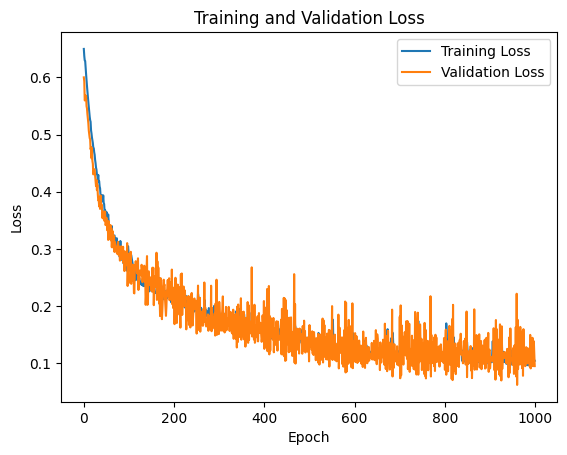

In [56]:
# Plotting de las pérdidas
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

- En el siguiente bloque evalue que tan bueno es su modelo mediante diferentes métricas

Confusion Matrix:
[[33  1]
 [ 3 77]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        34
           1       0.99      0.96      0.97        80

    accuracy                           0.96       114
   macro avg       0.95      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Accuracy: 0.9649122807017544


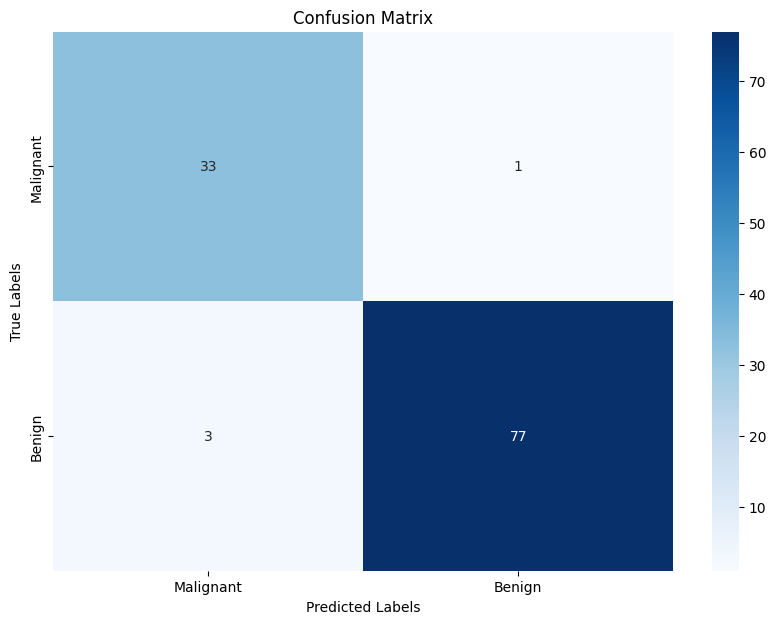

In [57]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Evaluar el modelo en el conjunto de prueba
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

# Calcular las métricas
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')
print(f'Accuracy: {accuracy}')

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'], 
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



- Concluya sobre su trabajo.  
- Responda
	- ¿Qué tan confiable sería su modelo en un entorno clínico? 
	- ¿Qué haría para mejorarlo?
	- Sobre la matriz de confusión, ¿Alguno de sus elementos son más importantes que otros en este caso?
	¿Que significaría el aumento de FN o FP en este caso? 
- Investigue sobre alguna arquitectura de red neuronal distinta a la utilizada en este trabajo, describala y explique en que casos sería útil.



### Pregunta Bonus
- ¿Cúal es la principal limitación de las redes neuronales comparado al cerebro humano?